In [43]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import colorsys
from math import pi, ceil, floor, cos, sin
import glob
import pandas as pd
#pip install plotly==5.3.1
from ipynb.fs.full.ploty_zoom import zoom

from skimage import io, morphology, img_as_bool, segmentation
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

_root       = "./samples/"

validation = "none" #unet/hsv/none
directory = "AMBOS" #NORMAL/AGLOMERADO/AMBOS


HEXAGONAL_MODE = False

In [44]:


def hexagon(img, pos, radius, color, line):

    def next_point(prev, line_length, angle):
        radians = angle * pi / 180
        return (int(prev[0] + line_length*cos(radians)),  
                int(prev[1] + line_length*sin(radians)))
    
    pts = [[pos[0]-radius,pos[1]]]
    pts.append(next_point(pts[0], radius, -60))
    pts.append(next_point(pts[1], radius, 0))
    pts.append(next_point(pts[2], radius, 60))
    pts.append(next_point(pts[3], radius, 120))
    pts.append(next_point(pts[4], radius, 180))

    pts = np.array(pts)
    pts = pts.reshape((-1,1,2))
    if line < 0:
        cv2.fillPoly(img,[pts],color)
    else:
        cv2.polylines(img,[pts],True,color, line)
    
    return img

def hexagon_cut(img):
    diam = img.shape[1]//3
    pos = (img.shape[1]//2,img.shape[0]//2)
    mask = np.zeros(img.shape, dtype='uint8')
    if len(img.shape) == 3:
        color = (1,1,1)
    else:
        color = 1
    
    mask = hexagon(mask, pos, diam, color, -1)
    
    img *= mask
    
    return img


Errors: 4


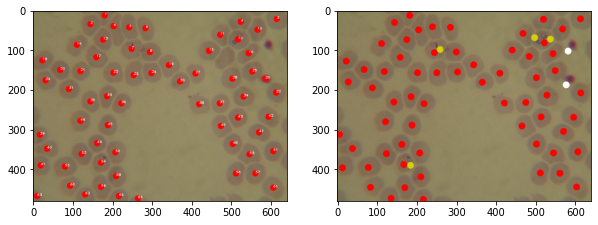

In [45]:
def not_yellow_random_color():
    color = np.random.randint(1,256, size=3)
    hsv = colorsys.rgb_to_hsv(color[0],color[1],color[2])
    if 30 <= hsv[0] <= 90:
        return not_yellow_random_color()
    return tuple((int(color[0]),int(color[1]),int(color[2])))
    



def compare_parasites_markers(manual, img):
    
    if type(manual) == str:
        manual = cv2.cvtColor(cv2.imread(manual,1), cv2.COLOR_BGR2RGB)
        manual = cv2.resize(manual,(640,480))
        
    if type(img) == str:
        img = cv2.cvtColor(cv2.imread(img,1), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(640,480))
    
    manual = manual.copy()
    img = img.copy()
    
    if HEXAGONAL_MODE:
        manual = hexagon_cut(manual)
    if HEXAGONAL_MODE:
        img = hexagon_cut(img)
    
    #encontra as marcações relacionadas
    img_mask    = cv2.inRange(cv2.cvtColor(img, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    manual_mask = cv2.inRange(cv2.cvtColor(manual, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    
    total_count1, _, stats1, centroids1 = cv2.connectedComponentsWithStats(img_mask, 4, cv2.CV_32S)
    total_count2, _, stats2, centroids2 = cv2.connectedComponentsWithStats(manual_mask, 4, cv2.CV_32S)
    
    for i in range(total_count1):
        if stats1[i, cv2.CC_STAT_AREA] > 1000:
            continue
        for y in range(total_count2):
            if stats2[y, cv2.CC_STAT_AREA] > 1000:
                continue
            
            dist = np.linalg.norm(centroids1[i]-centroids2[y])
            if dist < 30:
                color = not_yellow_random_color()
                cX, cY = centroids1[i]
                cv2.circle(img, (int(cX),int(cY)), 10, color, -1)
                cX, cY = centroids2[y]
                cv2.circle(manual, (int(cX),int(cY)), 10, color, -1)
                
                
    #conta quantas marcações amarelas sobraram
    img_mask    = cv2.inRange(cv2.cvtColor(img, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    manual_mask = cv2.inRange(cv2.cvtColor(manual, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    errors = 0
    
    total_count1, _, stats1, centroids1 = cv2.connectedComponentsWithStats(img_mask, 4, cv2.CV_32S)
    total_count2, _, stats2, centroids2 = cv2.connectedComponentsWithStats(manual_mask, 4, cv2.CV_32S)
    
    
#     plt.imshow(img_mask)
#     plt.show()
#     plt.imshow(manual_mask)
#     plt.show()
    errors = total_count1 + total_count2 - 2
    
    return errors, img, manual


if __name__ == "__main__":
    #manual = "./samples/normal/blood_smear_1_count.JPG"
    manual = "./samples/normal/blood_smear_7_count.JPG"
    manual = cv2.cvtColor(cv2.imread(manual,1), cv2.COLOR_BGR2RGB)
    manual = cv2.resize(manual,(640,480))
    #img = "./samples/segmented/hsv/blood_smear_1_otsu.png"
    img = "./samples/normal/blood_smear_7_segmented.png"
    img    = cv2.cvtColor(cv2.imread(img,1), cv2.COLOR_BGR2RGB)
    errors, img, manual = compare_parasites_markers(manual, img)

    print("Errors:", errors)
    fig, ax = plt.subplots(ncols=2, figsize=(10,10))
    ax[0].imshow(img)
    ax[1].imshow(manual)
    plt.show()

{'true_positive': 62, 'true_negative': 0, 'false_positive': 3, 'false_negative': 1, 'cells_qtd': 65}
Errors: 4


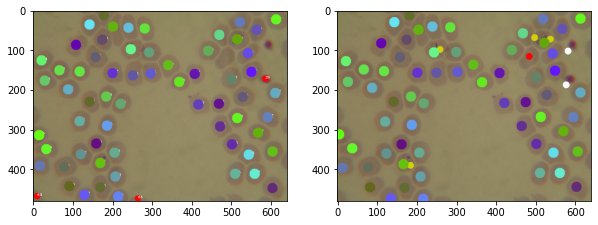

In [46]:


def get_img(name):
    if HEXAGONAL_MODE:
        return hexagon_cut(cv2.imread(name,1))
    else:
        return cv2.imread(name,1)
    
    
def not_red_random_color():
    color = np.random.randint(1,256, size=3)
    color[0] = 100
    if (color[1] < 100 and color[2] < 100):
        return not_red_random_color()
    elif (color[1] > 230 and color[2] > 230):
        return not_red_random_color()
    else:
        return tuple((int(color[0]),int(color[1]),int(color[2])))
    



def compare_markers(manual, img):
    
    if type(manual) == str:
        manual = cv2.cvtColor(cv2.imread(manual,1), cv2.COLOR_BGR2RGB)
        manual = cv2.resize(manual,(640,480))
        
    if type(img) == str:
        img = cv2.cvtColor(cv2.imread(img,1), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(640,480))
        
    manual = manual.copy()
    img = img.copy()
        
    if HEXAGONAL_MODE:
        manual = hexagon_cut(manual)
    if HEXAGONAL_MODE:
        img = hexagon_cut(img)
    
    
    true_positive = 0
    true_negative = 0 #nao sera usado
    false_positive = 0
    false_negative = 0
    
    errors = 0
    total = 0
    manual_total = 0
    max_area = 300#despreza as marcações das bordas
    min_area = 100
    
    #procura por todas as marcacoes que estejam em posicoes similares nas duas imagens
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    total_count, _, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    total += total_count - 1
        
    hsv = cv2.cvtColor(manual,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    manual_count, _, _, manual_centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    manual_total += manual_count -1
    
    #print("total", total, "manual_total", manual_total)
    
    
    #das celulas restantes procuro a marcação relacionada
    for m_c in manual_centroids:
        i = 0
        for c in centroids:
            dist = np.linalg.norm(c-m_c)
            if dist < 20 and stats[i, cv2.CC_STAT_AREA] < max_area:
                cX, cY = m_c
                color = not_red_random_color()
                cv2.circle(manual, (int(cX),int(cY)), 13, color, -1)
                cX, cY = c
                cv2.circle(img, (int(cX),int(cY)), 13, color, -1)
                break
            i += 1
        
    
    #conta as células que estao agrupadas
    #relacionando com as posicoes na contagem manual
    
    
    def has_more_groups(img, color):
        mask = cv2.inRange(img, (color,0,color), (255,0,255))
        return np.sum(mask)

    color = 50

    
    while (has_more_groups(img, color)):
        #encontra a caixa        
        mask = cv2.inRange(img, (color+2,0,color+2), (color+2,0,color+2))
        
        #preenche as bordas falhadas do retangulo
        image = img_as_bool(mask)
        out = ndi.distance_transform_edt(~image)
        out = out < 0.05 * out.max()
        out = morphology.skeletonize(out)
        out = morphology.binary_dilation(out) #, morphology.footprints) #morphology.selem.disk(1)
        out = segmentation.clear_border(out)
        out = out | image
        mask[out] = 255
        
        #encontra o retangulo que envolve as celulas
        cnts, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        max_area = 0
        sel = 0
        for c in range(len(cnts)):
            area = cv2.contourArea(cnts[c])
            if max_area < area:
                max_area = area
                sel = c
        x,y,w,h = cv2.boundingRect(cnts[sel])
        #cv2.rectangle(mask, (x,y), (x+w,y+h), 255, 3)
            
        
        #contagem das celulas encontradas pelo algoritmo
        #conta as celulas da cor da caixa
        mask_cells = cv2.inRange(img, (color,0,color), (color,0,color))
        box_count, _, _, _ = cv2.connectedComponentsWithStats(mask_cells, 4, cv2.CV_32S)
        #conta as celulas vermelhas ainda dentro da caixa
        img_cut = img[y:y+h,x:x+w]
        hsv = cv2.cvtColor(img_cut,cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
        num, _, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
        
        cell_count = 0
        for i in range(num):
            stat = stats[i]
            if (min_area < stat[cv2.CC_STAT_AREA] < max_area):
                center = centroids[i]
                cell_count += 1
                #marca as celulas que foram contadas na imagem original
                cX, cY = center
                cv2.circle(img, (x+int(cX),y+int(cY)), 13, (0,255,0), -1)
        cell_count += box_count-1
        
        true_positive = cell_count
        
        
        #conta as celulas dentro da caixa na contagem manual
        cut = manual[y:y+h,x:x+w]
        hsv = cv2.cvtColor(cut,cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
        num, _, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
        max_area = 300
        min_area = 100
        manual_count = 0
        for i in range(num):
            stat = stats[i]
            if (min_area < stat[cv2.CC_STAT_AREA] < max_area):
                manual_count += 1
                center = centroids[i]
                #marca as celulas que foram contadas na imagem original
                cX, cY = center
                cv2.circle(manual, (x+int(cX),y+int(cY)), 13, (0,255,0), -1)
        
        
        mask_cells = mask_cells[y:y+h,x:x+w]
        
        total        += cell_count
        manual_total += manual_count
        #print("count",cell_count, "manual",manual_count)
        
        err = cell_count - manual_count
        if (err > 0):
            false_positive += abs(err)
        else:
            false_negative += abs(err)
        errors += abs(err)
        
        color += 5

        
    #conta quantas marcacoes vermelhas sobraram em ambas
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    total_error, _, _, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    total_error -= 1
    false_positive += total_error
        
    hsv = cv2.cvtColor(manual,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    manual_error, _, _, manual_centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    manual_error -= 1
    false_negative += manual_error
    
    errors += total_error + manual_error
    
    true_positive = total - false_positive
    
    return errors, img, manual, {"true_positive":true_positive, 
                                 "true_negative":true_negative,
                                 "false_positive":false_positive, 
                                 "false_negative":false_negative,
                                 "cells_qtd": total}


if __name__ == "__main__":
    #87 semar_8
    #95 manual
    manual = cv2.cvtColor(cv2.imread("./samples/normal/blood_smear_7_count.JPG",1), cv2.COLOR_BGR2RGB)
    #manual = cv2.cvtColor(cv2.imread("./samples/aglomerado/blood_smear_8_count.JPG",1), cv2.COLOR_BGR2RGB)
    manual = cv2.resize(manual,(640,480))
    img    = cv2.cvtColor(cv2.imread("./samples/normal/blood_smear_7_segmented.png",1), cv2.COLOR_BGR2RGB)
    #img    = cv2.cvtColor(cv2.imread("./samples/aglomerado/blood_smear_8_segmented.png",1), cv2.COLOR_BGR2RGB)
    errors, img, manual, st = compare_markers(manual, img)

    
    print(st)
    print("Errors:", errors)
    fig, ax = plt.subplots(ncols=2, figsize=(10,10))
    ax[0].imshow(img)
    ax[1].imshow(manual)
    plt.show()

{'true_positive': 80, 'true_negative': 0, 'false_positive': 15, 'false_negative': 17, 'cells_qtd': 95}
Errors: 32


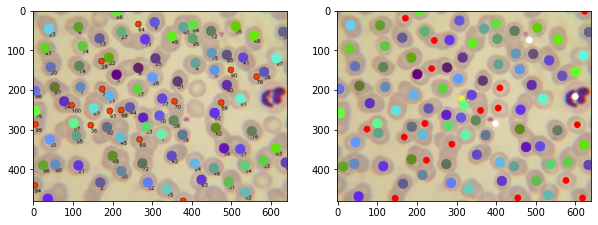

In [47]:
#87 semar_8
#95 manual
if __name__ == "__main__":

    manual = cv2.cvtColor(cv2.imread("./samples/aglomerado/blood_smear_8_count.JPG",1), cv2.COLOR_BGR2RGB)
    manual = cv2.resize(manual,(640,480))
    img    = cv2.cvtColor(cv2.imread("./samples/segmented/hsv/blood_smear_8_hough.png",1), cv2.COLOR_BGR2RGB)
    errors, img, manual, st = compare_markers(manual, img)

    print(st)
    print("Errors:", errors)
    fig, ax = plt.subplots(ncols=2, figsize=(10,10))
    ax[0].imshow(img)
    ax[1].imshow(manual)
    plt.show()

In [48]:
def getManualCount(name):
    return {"method":"Manual", "path":name, "time":0}


def getOriginalCount(directory,name):
    name1 = name.replace(directory,_root+"result/") + "_resultText.txt"
    f = open(name1,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.split("\n")
    data = lines[1].split()
    
    return {"method"  :"Original",
            "time"    :float(data[4]),
            "path"    :name+"_segmented.png"}

def getProjectCount(directory,validation,name):
    name = name.replace(directory,_root+"myresults/"+validation+"/") + "_result.txt"
    f = open(name,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.split("\n")
    ret = []
    for i in range(1,len(lines),1):
        data = lines[i].split("\t")
        if len(data) > 1:
            ret.append({
                'method'  : data[0].strip(),
                'time'    : float(data[4].strip().replace("s","")),
                'path'    : data[5].strip(),
            })
    return ret


def add_to_samples(samples,values):
    if "cells_error" not in values.keys():
        values['cells_error'] = -1
    if "infection_error" not in values.keys():
        values['infection_error'] = -1
    if ("true_positive" not in values.keys()):
        values["true_positive"] = -1
        values["true_negative"] = -1
        values["false_positive"] = -1
        values["false_negative"] = -1
        
    
    samples['method'].append(values["method"])
    samples['time'].append(values["time"])
    samples['path'].append(values["path"])
    samples['cells_error'].append(values["cells_error"])
    #samples['cells_qtd'].append(values["cells_qtd"])
    samples['infection_error'].append(values["infection_error"])
    samples["true_positive"].append(values["true_positive"])
    samples["true_negative"].append(values["true_negative"])
    samples["false_positive"].append(values["false_positive"])
    samples["false_negative"].append(values["false_negative"])
    #(TP+TN)/(TP+TN+FP+FN)
    acc = (values["true_positive"]+values["true_negative"])/(values["true_positive"]+values["true_negative"]+values["false_positive"]+values["false_negative"])
    #acc = values["true_positive"]/(values["true_positive"]+values["true_negative"]+values["false_positive"]+values["false_negative"])
    samples["acc"].append(acc)
    precision = values["true_positive"]/(values["true_positive"]+values["false_positive"])
    samples["precision"].append(precision)
    recall = values["true_positive"]/(values["true_positive"]+values["false_negative"])
    samples["recall"].append(recall)
    f1 = (2*precision*recall)/(precision+recall)
    samples["f1-score"].append(f1)
    
    
    
def read_result_data(group, validation):
    
    if group == "AGLOMERADO":
        directory = "./samples/aglomerado/"
    elif group == "NORMAL":
        directory = "./samples/normal/"
    else:
        sp1 = read_result_data("AGLOMERADO", validation)
        sp2 = read_result_data("NORMAL", validation)
        return sp1.append(sp2)

    samples = {"sample":[],
               "method":[],
               "time":[],
               "path":[],
               "infection_error":[],
               "cells_error":[],
               "true_positive":[],
               "true_negative":[], #nao usado
               "false_positive":[],
               "false_negative":[],
               "acc":[],
               "precision":[],
               "recall":[],
               "f1-score":[]}
               #"cells_qtd":[]}

    qtd = 0
    for file in glob.glob(directory+"*_count.jpg"):
        qtd += 1
        
        #nome da amostra
        file = file.replace("\\","/").lower()
        name = file.replace("_count.jpg","")
        sample_name = name.replace(directory,"")
        samples['sample'].append(sample_name)

        #adiciona os dados do Ground truth a base
        manual = getManualCount(file)
        add_to_samples(samples,manual)

        #le os dados obtidos pelo projeto
        data = getProjectCount(directory, validation, name)
        for dt in data:
            #adiciona na base
            samples['sample'].append(sample_name)
            dt['cells_error'], _, _, st = compare_markers(file, dt['path'])
            dt['infection_error'], _, _ = compare_parasites_markers(file, dt['path'])
            
            dt["true_positive"]  = st["true_positive"]
            dt["true_negative"]  = st["true_negative"]
            dt["false_positive"] = st["false_positive"]
            dt["false_negative"] = st["false_negative"]
            #dt["cells_qtd"]      = st["cells_qtd"]
            
            
            add_to_samples(samples,dt)

            
        #le os dados do projeto original
        orig = getOriginalCount(directory, name)
        samples['sample'].append(sample_name)
        print("reading",orig['path'])
        orig['cells_error'], _, _, st = compare_markers(file, orig['path'])
        orig['infection_error'], _, _ = compare_parasites_markers(file, orig['path'])
        
        orig["true_positive"]  = st["true_positive"]
        orig["true_negative"]  = st["true_negative"]
        orig["false_positive"] = st["false_positive"]
        orig["false_negative"] = st["false_negative"]
        #orig["cells_qtd"]      = st["cells_qtd"]
        
        #adiciona na base
        add_to_samples(samples,orig)

    samples = pd.DataFrame(data=samples)
    return samples

if __name__ == "__main__":
    samples = read_result_data(directory, validation)

reading ./samples/aglomerado/blood_smear_12_segmented.png
reading ./samples/aglomerado/blood_smear_13_segmented.png
reading ./samples/aglomerado/blood_smear_14_segmented.png
reading ./samples/aglomerado/blood_smear_19_segmented.png
reading ./samples/aglomerado/blood_smear_20_segmented.png
reading ./samples/aglomerado/blood_smear_21_segmented.png
reading ./samples/aglomerado/blood_smear_22_segmented.png
reading ./samples/aglomerado/blood_smear_23_segmented.png
reading ./samples/aglomerado/blood_smear_24_segmented.png
reading ./samples/aglomerado/blood_smear_25_segmented.png
reading ./samples/aglomerado/blood_smear_26_segmented.png
reading ./samples/aglomerado/blood_smear_27_segmented.png
reading ./samples/aglomerado/blood_smear_28_segmented.png
reading ./samples/aglomerado/blood_smear_29_segmented.png
reading ./samples/aglomerado/blood_smear_8_segmented.png
reading ./samples/aglomerado/blood_smear_9_segmented.png
reading ./samples/normal/blood_smear_11_segmented.png
reading ./samples/no

In [49]:
samples

,sample,method,time,path,infection_error,cells_error,true_positive,true_negative,false_positive,false_negative,acc,precision,recall,f1-score
0,blood_smear_12,Manual,0.000000,./samples/aglomerado/blood_smear_12_count.jpg,-1,-1,-1,-1,-1,-1,0.500000,0.500000,0.500000,0.500000
1,blood_smear_12,OTSU,0.370000,./samples/segmented/none/blood_smear_12_otsu.png,1,42,61,0,6,36,0.592233,0.910448,0.628866,0.743902
2,blood_smear_12,OTSU w/out blur,0.470000,./samples/segmented/none/blood_smear_12_otsu_o...,1,37,64,0,4,33,0.633663,0.941176,0.659794,0.775758
3,blood_smear_12,HSV,0.570000,./samples/segmented/none/blood_smear_12_hsv.png,1,50,49,0,3,47,0.494949,0.942308,0.510417,0.662162
4,blood_smear_12,HSV convex hull,1.500000,./samples/segmented/none/blood_smear_12_hsv_hu...,1,59,47,0,8,51,0.443396,0.854545,0.479592,0.614379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,blood_smear_7,Hough Circles,0.100000,./samples/segmented/none/blood_smear_7_hough.png,4,5,60,0,2,3,0.923077,0.967742,0.952381,0.960000
139,blood_smear_7,OTSU + Hough v2,0.500000,./samples/segmented/none/blood_smear_7_otsu_ho...,4,13,60,0,10,3,0.821918,0.857143,0.952381,0.902256
140,blood_smear_7,OTSU + Hough v1,0.440000,./samples/segmented/none/blood_smear_7_otsu_ho...,4,12,62,0,11,1,0.837838,0.849315,0.984127,0.911765
141,blood_smear_7,U-net,0.440000,./samples/segmented/none/blood_smear_7_unet.png,4,8,59,0,4,4,0.880597,0.936508,0.936508,0.936508


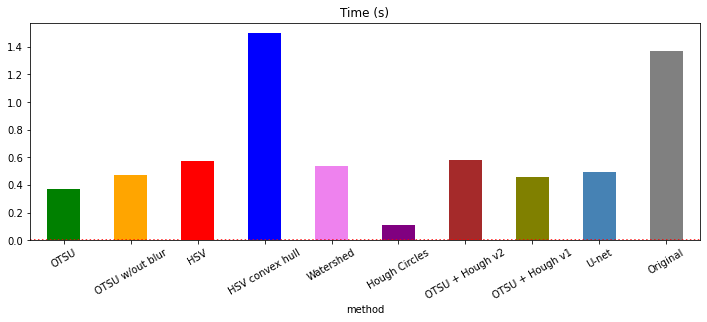

In [50]:
def graph(smp_name,value):
    smp = samples.query("method != 'Manual'  & sample == '%s'"%smp_name)
    ax = smp[["method",value]].plot.bar(x='method',
                                        y=value,
                                        color=['green','orange','red',
                                               'blue','violet','purple',
                                               'brown', 'olive','steelblue', 'gray'],
                                        title=smp_name,
                                        figsize=(12,4),
                                        rot=30)
    manual_count = samples.query("method == 'Manual' & sample == '%s'" % smp_name).iloc[0][value]


    ax.axhline(y=manual_count, color='r', linestyle='dotted')
    ax.get_legend().remove()
    
    plt.title('Time (s)')
    
if __name__ == "__main__":
    graph(samples['sample'].iloc(0)[0],"time")

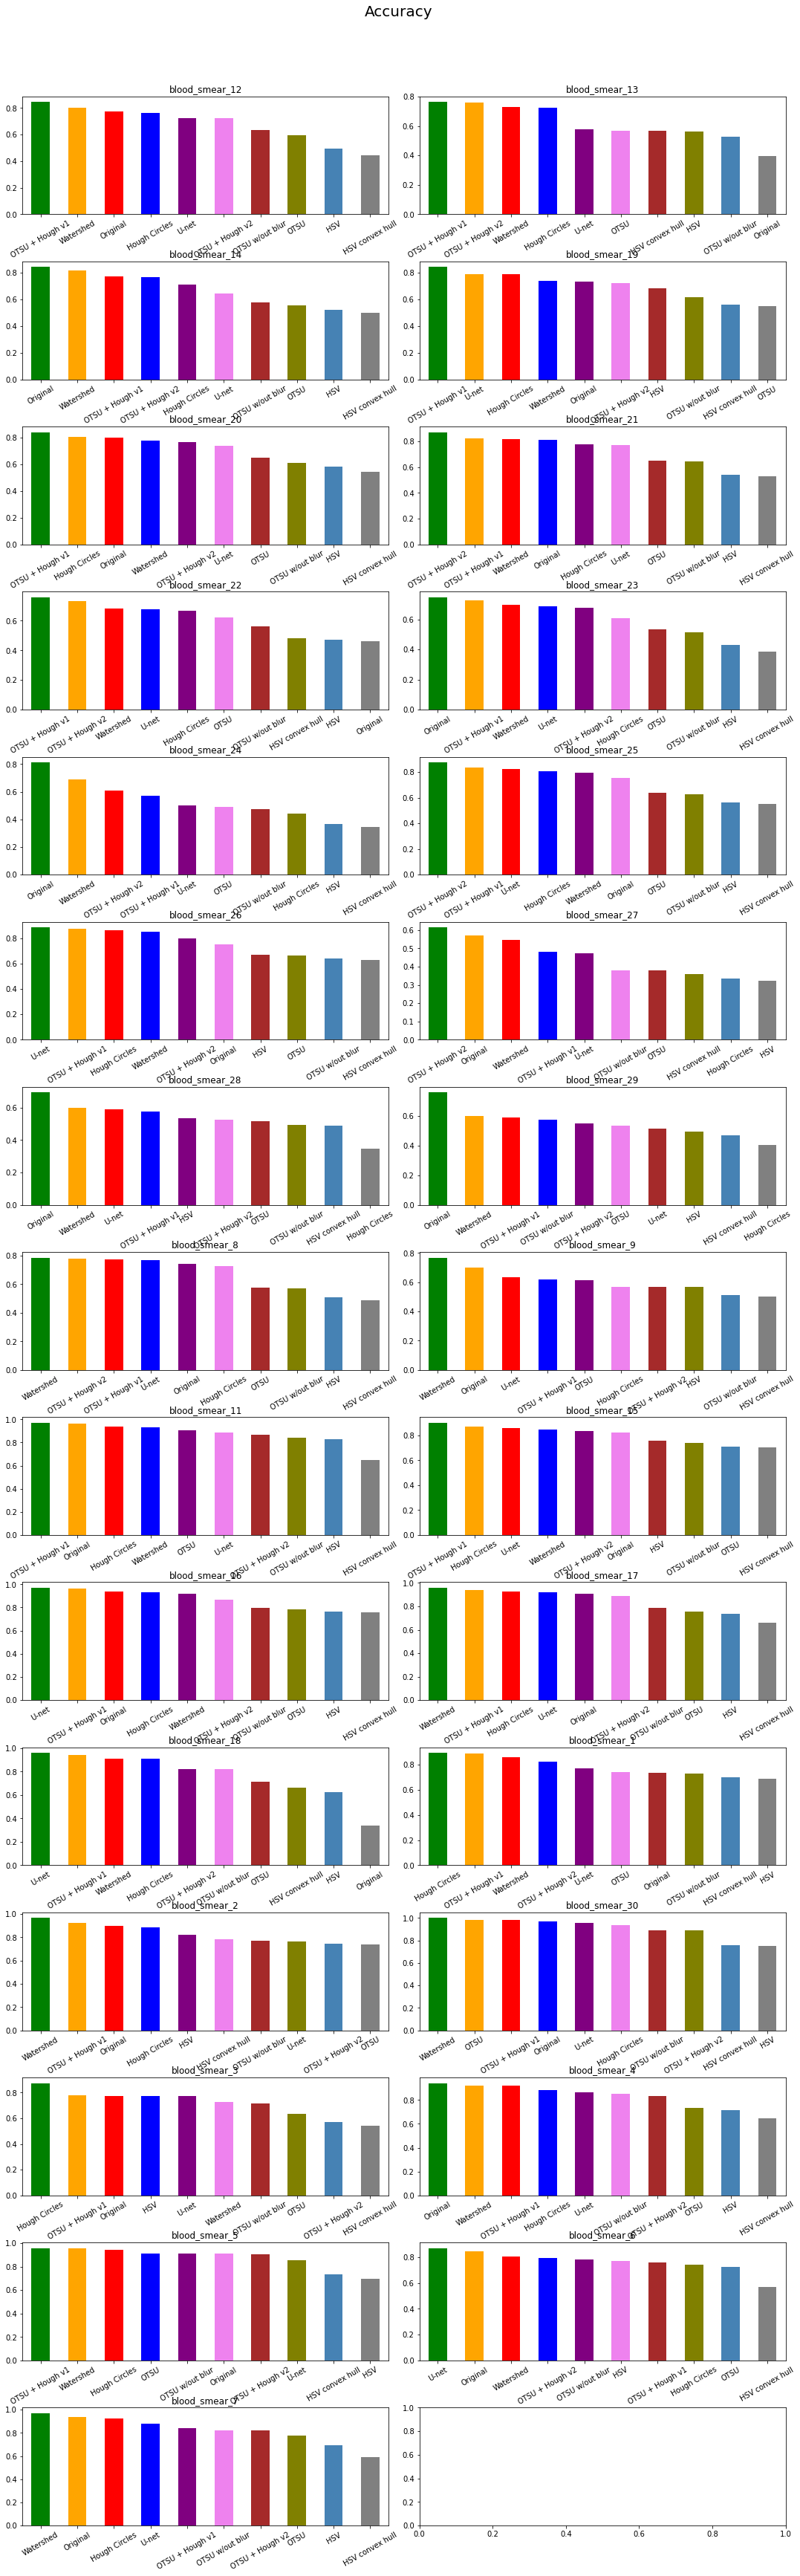

In [51]:
if __name__ == "__main__":

    samples_list = samples[["sample"]].drop_duplicates().values
    samples_list = samples_list.reshape(len(samples_list))
    
    lim = 15

    fig, axes = plt.subplots(ncols=2,nrows=lim,figsize=(15,50))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle("Accuracy", fontsize=20)
    plt.subplots_adjust(hspace = .4)

    pos = [(j,i) for j in range(lim) for i in range(2)]
    i = 0
    for smp_name in samples_list:

        smp = samples.query("method != 'Manual' & sample == '%s'" % smp_name)
        smp = smp.sort_values('acc',ascending=False)
        ax = smp[["method","acc"]].plot.bar(x='method',
                                            y='acc',
                                            color=['green','orange','red',
                                                   'blue','purple','violet',
                                                   'brown', 'olive','steelblue', 'gray'],
                                            ax=axes[pos[i]],
                                            title=smp_name,
                                            rot=30)
        ax.get_legend().remove()
        ax.set_xlabel('')
        i += 1



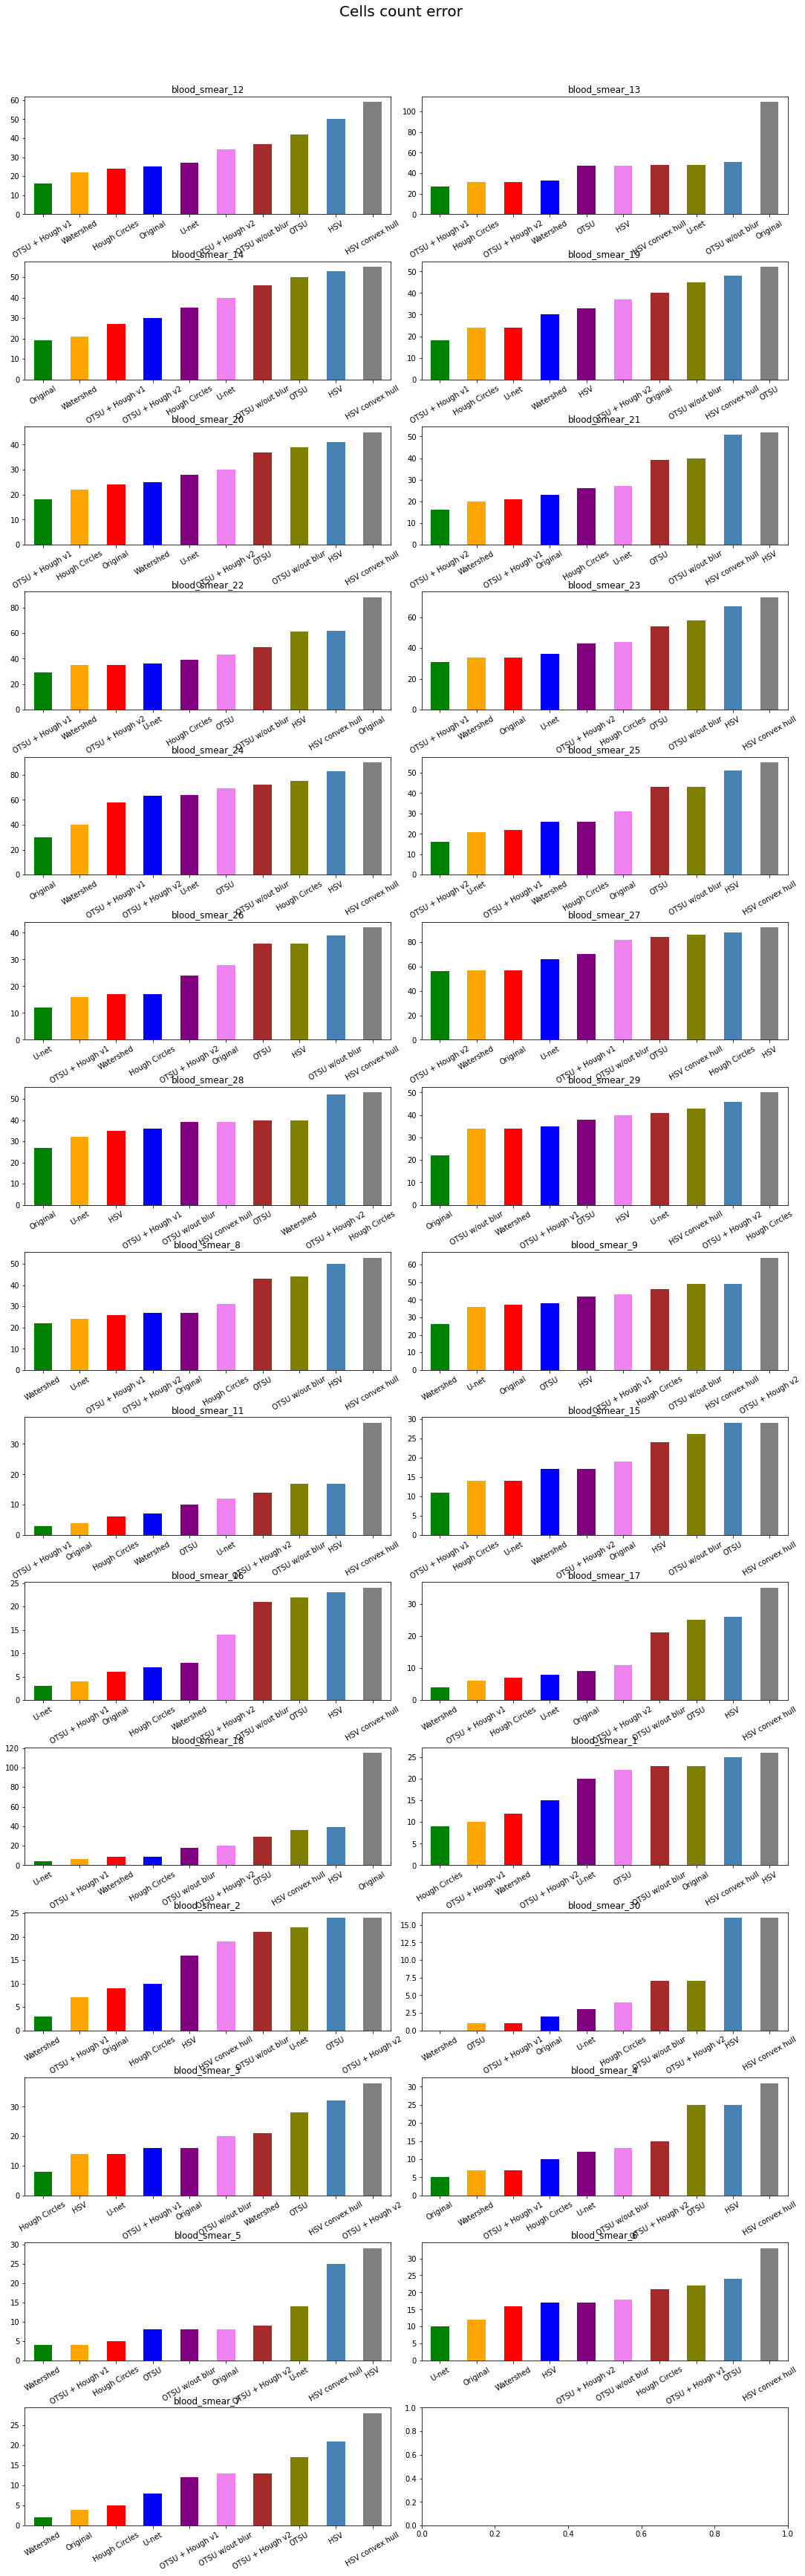

In [52]:
if __name__ == "__main__":

    samples_list = samples[["sample"]].drop_duplicates().values
    samples_list = samples_list.reshape(len(samples_list))

    lim = 15
    fig, axes = plt.subplots(ncols=2,nrows=lim,figsize=(15,50))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle("Cells count error", fontsize=20)
    plt.subplots_adjust(hspace = .4)

    pos = [(j,i) for j in range(lim) for i in range(2)]
    i = 0
    for smp_name in samples_list:

        smp = samples.query("method != 'Manual' & sample == '%s'" % smp_name)
        smp = smp.sort_values('cells_error')
        ax = smp[["method","cells_error"]].plot.bar(x='method',
                                                    y='cells_error',
                                                    color=['green','orange','red',
                                                           'blue','purple','violet',
                                                           'brown', 'olive','steelblue', 'gray'],
                                                    ax=axes[pos[i]],
                                                    title=smp_name,
                                                    rot=30)
        ax.get_legend().remove()
        ax.set_xlabel('')
        i += 1



In [53]:
directory + " " + validation

'AMBOS none'

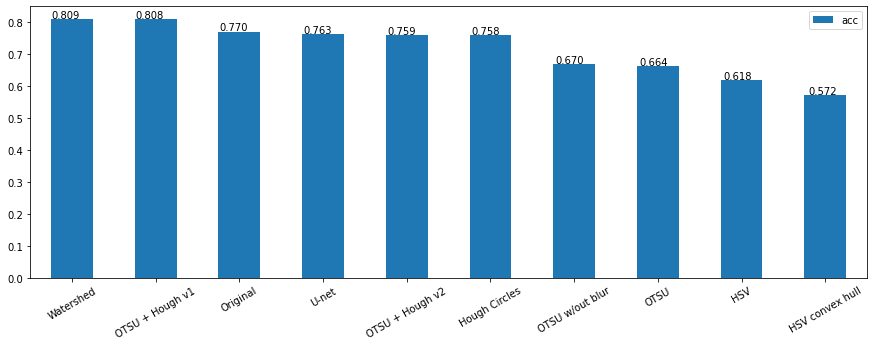

In [54]:
if __name__ == "__main__":
    smp = samples.query("method != 'Manual'")
    smp = smp[["method","acc"]].groupby("method").mean().sort_values("acc",ascending=False)
    #smp
    ax = smp.plot.bar(figsize=(15,5),rot=30)
    ax.set_xlabel('')
    for p in ax.patches:
        ax.annotate("%.3f"  % p.get_height(), (p.get_x() * 1.005, p.get_height() * 1.005))

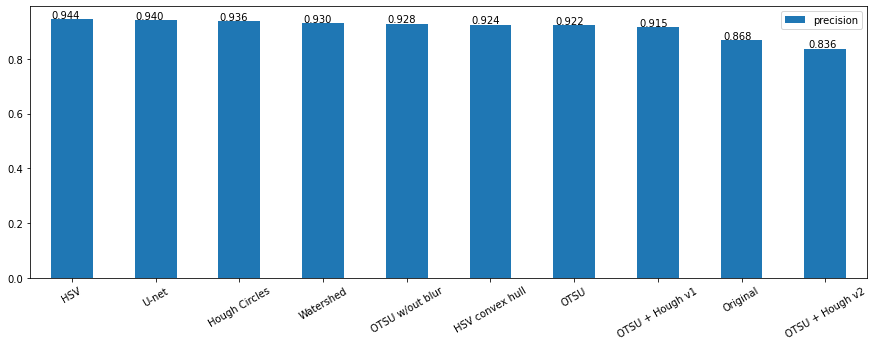

In [55]:
if __name__ == "__main__":
    smp = samples.query("method != 'Manual'")
    smp = smp[["method","precision"]].groupby("method").mean().sort_values("precision",ascending=False)
    #smp
    ax = smp.plot.bar(figsize=(15,5),rot=30)
    ax.set_xlabel('')
    for p in ax.patches:
        ax.annotate("%.3f"  % p.get_height(), (p.get_x() * 1.005, p.get_height() * 1.005))

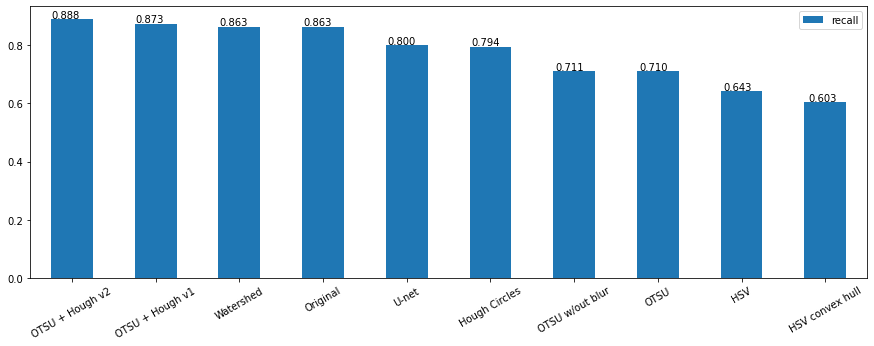

In [56]:
if __name__ == "__main__":
    smp = samples.query("method != 'Manual'")
    smp = smp[["method","recall"]].groupby("method").mean().sort_values("recall",ascending=False)
    #smp
    ax = smp.plot.bar(figsize=(15,5),rot=30)
    ax.set_xlabel('')
    for p in ax.patches:
        ax.annotate("%.3f"  % p.get_height(), (p.get_x() * 1.005, p.get_height() * 1.005))

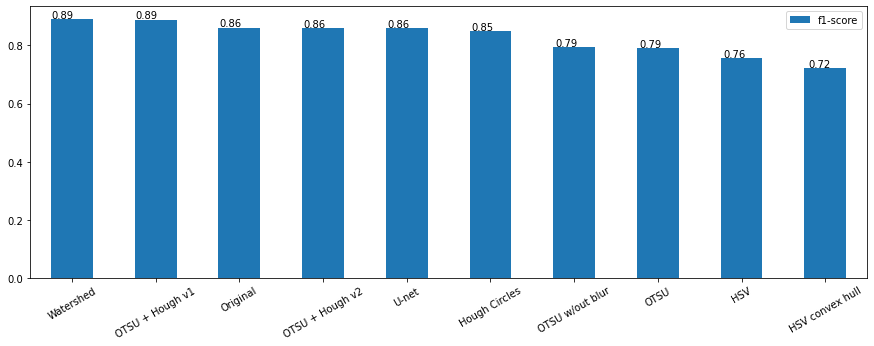

In [57]:
if __name__ == "__main__":
    smp = samples.query("method != 'Manual'")
    smp = smp[["method","f1-score"]].groupby("method").mean().sort_values("f1-score",ascending=False)
    #smp
    ax = smp.plot.bar(figsize=(15,5),rot=30)
    ax.set_xlabel('')
    for p in ax.patches:
        ax.annotate("%.2f"  % p.get_height(), (p.get_x() * 1.005, p.get_height() * 1.005))

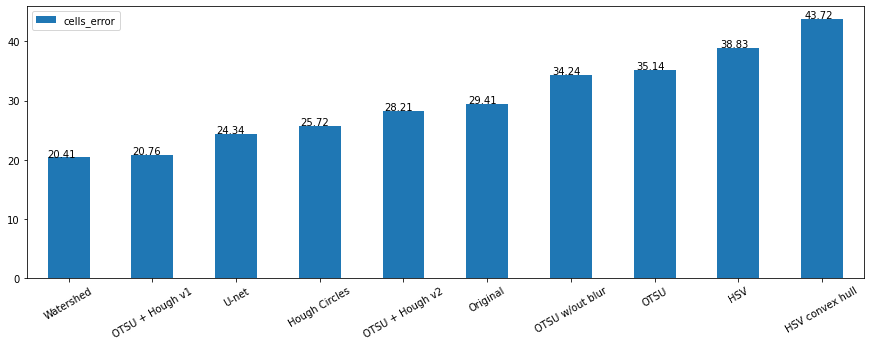

In [58]:
if __name__ == "__main__":
    smp = samples.query("method != 'Manual'")
    smp = smp[["method","cells_error"]].groupby("method").mean().sort_values("cells_error",ascending=True)
    #smp
    ax = smp.plot.bar(figsize=(15,5),rot=30)
    ax.set_xlabel('')
    for p in ax.patches:
        ax.annotate("%.2f"  % p.get_height(), (p.get_x() * 1.005, p.get_height() * 1.005))

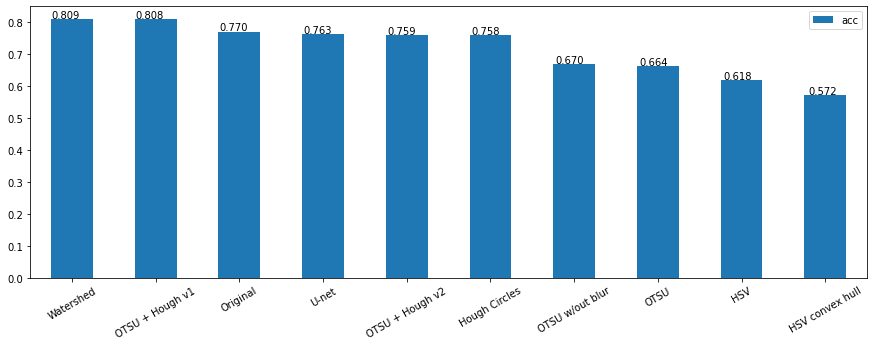

In [59]:
if __name__ == "__main__":
    smp = samples.query("method != 'Manual'")
    smp = smp[["method","acc"]].groupby("method").mean().sort_values("acc",ascending=False)
    #smp
    ax = smp.plot.bar(figsize=(15,5),rot=30)
    ax.set_xlabel('')
    for p in ax.patches:
        ax.annotate("%.3f"  % p.get_height(), (p.get_x() * 1.005, p.get_height() * 1.005))

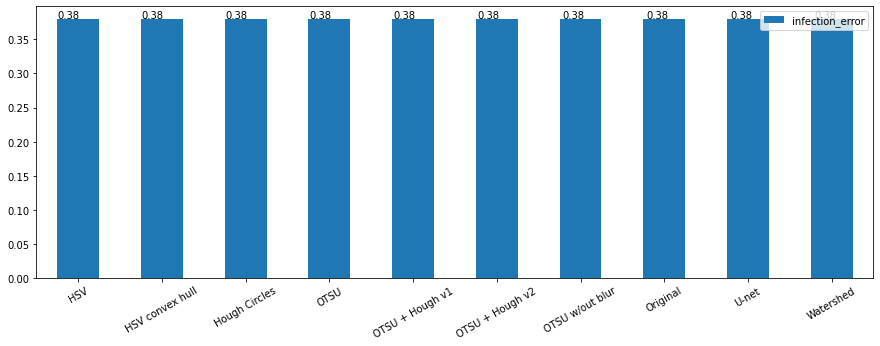

In [60]:
if __name__ == "__main__":
    smp = samples.query("method != 'Manual'")
    smp = smp[["method","infection_error"]].groupby("method").mean().sort_values("infection_error")
    #smp
    ax = smp.plot.bar(figsize=(15,5),rot=30)
    ax.set_xlabel('')
    for p in ax.patches:
        ax.annotate("%.2f"  % p.get_height(), (p.get_x() * 1.005, p.get_height() * 1.005))